## Embeddings


Embeddings são representações numéricas que traduzem dados de alta dimensão, como texto, imagens ou áudio, em vetores de dimensão reduzida. Esses vetores preservam relações semânticas ou contextuais do dado original, permitindo que informações complexas sejam manipuladas de forma mais eficiente em cálculos e algoritmos.

No caso de textos, por exemplo, um embedding transforma palavras, frases ou documentos em números de tal forma que palavras com significados semelhantes fiquem próximas no espaço vetorial. Por exemplo, podemos dizer que a palavra homem está para a palavra rei, da mesma forma que a palavra mulher está para a palavra rainha. Esses significados semânticos servem como ferramenta para que possamos obter contextos dentro de situações em que precisamos dele.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

from dotenv import load_dotenv
import os

from tqdm import tqdm

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
embedding_size = 1536
embedding_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embedding_model, dimensions=embedding_size)

## Carregando os dados:

Instanciando o [`PyPDFLoader`](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/), temos um objeto de loader do lanchain. No momento em que essa classe é instanciada, colocamos o caminho do arquivo PDF que queremos ler, e o objeto resultante tem um método chamado .load(). 
Esse método permite a leitura do arquivo PDF, e o resultado é o texto presente no PDF dentro de um objeto "Document", que faz parte da biblioteca do langchain e é a base dessa dinâmica de leitura de documentos da biblioteca.

In [5]:
file_path_ed_financeira = "../data/educacao_financeira.pdf"
file_path_historia = "../data/historia.pdf"
loader_historia = PyPDFLoader(file_path_historia)
loader_ed_financeira = PyPDFLoader(file_path_ed_financeira)
pages_historia = loader_historia.load()
pages_ed_financeira = loader_ed_financeira.load()

In [6]:
# Concatenante todo o conteudo em uma string só

all_content_pages_historia = "\n\n".join([page.page_content for page in pages_historia])
all_content_pages_ed_financeira = "\n\n".join([page.page_content for page in pages_ed_financeira])

## Text Splitter

Utilizamos uma técnica de text splitting para quebrar os textos em chunks (fragmentos menores). Isso é interessante no nosso contexto porque facilita o processamento e a análise de textos longos em tarefas como classificação ou geração de respostas. 

[`Recursive Text Splitter`](https://python.langchain.com/docs/how_to/recursive_text_splitter/).

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500,
    length_function=len,
    is_separator_regex=False,
)

In [8]:
##Aqui, temos como output uma lista de documents, onde cada document é um chunk do documento original
chunks_historia = text_splitter.split_documents(pages_historia)
chunks_ed_financeira = text_splitter.split_documents(pages_ed_financeira)

## Criando embeddings

Aqui, nós criamos os embeddings utilizando o [`OpenAIEmbeddings`](https://python.langchain.com/docs/integrations/text_embedding/openai/), e transformamos esses embeddings em arrays do numpy, que otimiza o uso desses embeddings para cálculos.

Criamos embeddings para os textos de história e educação financeira separadamente, e depois concatenamos (juntamos) os dois tipos de embeddings em um array só com todos os embeddings

In [9]:
vectors_historia = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_historia]))

In [10]:
vectors_ed_financeira = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_ed_financeira]))

In [11]:
all_vectors = np.concatenate([vectors_historia, vectors_ed_financeira], axis=0)

In [12]:
vectors_ed_financeira.shape, vectors_historia.shape, all_vectors.shape

((227, 1536), (333, 1536), (560, 1536))

## Reduzindo a dimensionalidade

Embeddings possuem uma quantidade significativa de dimensões. Para facilitar a compreensão, pense nas três dimensões que observamos no espaço ao nosso redor: altura, largura e profundidade. Com elas, conseguimos descrever a posição de qualquer objeto no espaço. Agora, imagine lidar com mais de 1000 dimensões. É impossível visualizar ou compreender intuitivamente esse espaço, mesmo que ele carregue significados importantes.

Para lidar com essa complexidade, utilizamos técnicas de redução de dimensionalidade, que permitem diminuir o número de dimensões sem perder as características principais dos dados. Uma dessas técnicas amplamente utilizadas é o t-SNE (t-Distributed Stochastic Neighbor Embedding). Essa técnica é capaz de projetar dados de alta dimensão em um espaço de dimensões menores, geralmente 2 ou 3, preservando as relações de proximidade entre os pontos no espaço original.

Não é necessário nos preocuparmos com os detalhes matemáticos dessa técnica, pois bibliotecas como o sklearn.manifold já oferecem implementações eficientes. Podemos utilizá-la para reduzir os nossos embeddings para 2 dimensões, permitindo que eles sejam visualizados em um plano 2D.

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
all_vectors_tsne = tsne.fit_transform(all_vectors)

c:\Users\gabri\Documents\nero\nero-summer-25-1\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gabri\Documents\nero\nero-summer-25-1\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


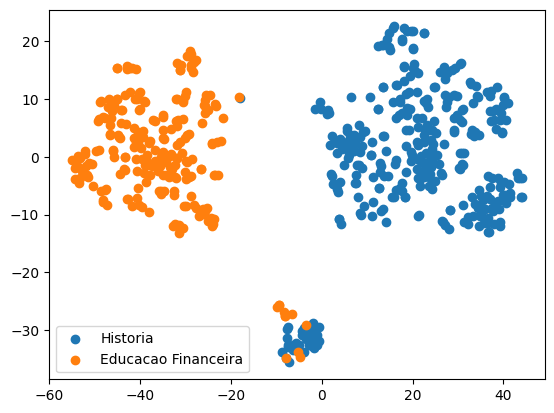

In [14]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.legend()
plt.show()

### Classificador 

Aqui, para confirmar a hipótese de que os embeddings carregam significado, construímos um classificador simples com a tarefa de prever a qual classe um chunk de texto pertence.

In [15]:
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split

class Classifier(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
input_size = embedding_size
criterion = nn.CrossEntropyLoss()
classifier = Classifier(input_size, 100, 2)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

X = torch.tensor(all_vectors, dtype=torch.float32)
y = torch.tensor([0]*len(vectors_historia) + [1]*len(vectors_ed_financeira), dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.687089741230011
Epoch 1 Loss: 0.6797249913215637
Epoch 2 Loss: 0.6714028120040894
Epoch 3 Loss: 0.6619876027107239
Epoch 4 Loss: 0.6517800092697144
Epoch 5 Loss: 0.6409651041030884
Epoch 6 Loss: 0.6296144723892212
Epoch 7 Loss: 0.6178084015846252
Epoch 8 Loss: 0.6056717038154602
Epoch 9 Loss: 0.5933023691177368
Epoch 10 Loss: 0.5807589292526245
Epoch 11 Loss: 0.5681090950965881
Epoch 12 Loss: 0.5554088950157166
Epoch 13 Loss: 0.5427268147468567
Epoch 14 Loss: 0.5301352739334106
Epoch 15 Loss: 0.517687976360321
Epoch 16 Loss: 0.5054276585578918
Epoch 17 Loss: 0.4934065341949463
Epoch 18 Loss: 0.48169779777526855
Epoch 19 Loss: 0.47040271759033203
Epoch 20 Loss: 0.4596002995967865
Epoch 21 Loss: 0.4493459165096283
Epoch 22 Loss: 0.4396657943725586
Epoch 23 Loss: 0.4305734634399414
Epoch 24 Loss: 0.4220800995826721
Epoch 25 Loss: 0.41418689489364624
Epoch 26 Loss: 0.4068872630596161
Epoch 27 Loss: 0.40016406774520874
Epoch 28 Loss: 0.39399027824401855
Epoch 29 Loss: 0.3883

In [17]:
from sklearn.metrics import accuracy_score, classification_report

outputs_test = classifier(X_test)
_, predicted = torch.max(outputs_test, 1)

print(accuracy_score(y_test, predicted))

1.0


In [18]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        39

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



## Entropia

A entropia é uma medida da incerteza ou desordem associada a uma distribuição de probabilidade. Em termos mais simples, ela indica o quão confuso ou "em dúvida" um sistema está ao tomar uma decisão. Em modelos de classificação, a entropia é frequentemente usada para avaliar o grau de incerteza nas previsões do modelo

Quando um classificador é treinado para categorizar chunks de texto em diferentes classes, ele gera uma distribuição de probabilidade para cada chunk, indicando a probabilidade de pertencer a cada classe. Se o modelo atribui alta probabilidade a uma única classe (baixa entropia), ele está confiante em sua previsão. Por outro lado, se as probabilidades estão espalhadas entre várias classes (alta entropia), o modelo está incerto sobre qual classe o chunk pertence.

In [19]:
def shannon_entropy(p):
    return -np.sum(p * np.log2(p))

all_outputs = classifier(X)
entropy = np.array([shannon_entropy(x) for x in all_outputs.detach().numpy()])
all_chunks = np.array([x.page_content for x in (chunks_historia + chunks_ed_financeira)])

df = pd.DataFrame({"entropy": entropy, 
                   "text": all_chunks, 
                   "label": y.numpy()})

In [20]:
df.sort_values("entropy", ascending=False).head(75)

,entropy,text,label
435,0.999995,70,1
2,0.997687,Vitória \n2015\nUniVersidade Federal do espíri...,0
436,0.993458,71,1
10,0.922129,8,0
506,0.855159,"Há muitos, muitos poucos anos, não existia cel...",1
...,...,...,...
334,0.122751,1\nEducação \nfinancEira\nnas Escolas\nEnsino ...,1
300,0.120422,fície é do tamanho da terra. É muito difícil q...,0
510,0.114548,134,1
415,0.112578,53\nSérgio se formou na mesma turma \nque Tia...,1


In [21]:
df.iloc[506, 1]

'Há muitos, muitos poucos anos, não existia celular. E, mesmo \nassim, as pessoas conseguiam se encontrar. Naquela época, \nos pais e as mães esperavam os filhos em casa pacientemen-\nte, já que não podiam ligar o tempo todo. E mensagem de tex-\nto só existia nos bilhetes passados em sala de aula, no tempo \nem que “vc” era você!\nli gar pela primeira vez para uma menina de quem você está \nafim antes de existir o celular:\nPaulo liGa Para a casa da marina (17:30): Triiiim... \nTriiiiim...\nirmão mais vElho, ciumEnTo E muiTo forTE da \nmarina: ALÔ!!!!!!!\nPaulo dEsliGa: Tú, tú, tú, tú.\nPaulo liGa Para a casa da marina (18:43): Triiiim... \nTriiiiim.... Triiiiiiimmmm....\nPai da marina aTEndE: Pronto.\nPaulo dEsliGa: Tú, tú, tú, tú.\ndia sEGuinTE, Paulo liGa Para a casa da marina \n(19:01): Triiiim... Triiiiim....\nmãE da marina aTEndE: Oi!\nPaulo dEsliGa: Tú, tú, tú, tú.\nTrÊs dias dEPois, Paulo liGa Para a casa da marina \n(17:06): Triiiim... Triiiiim... Triiiiiiimmmm...\nmarina aTEn

In [22]:
df.sort_values("entropy", ascending=True).head(15)

,entropy,text,label
232,0.002842,"158\nEssa filosofia, proveniente do mundo orie...",0
320,0.003523,"224\nfé, filosofia e teologia têm o mesmo obje...",0
167,0.003527,"118\nséculo xii e inícios do século xiii, o pr...",0
134,0.003618,"94\nse satisfaz com os bens finitos, mas almej...",0
224,0.003913,153\nUm autor absolutamente fundamental para s...,0
169,0.004158,119\nEm seus dois comentários as respostas dad...,0
15,0.004385,"pode mais falar de aristotelismo, mas de tomis...",0
168,0.004460,"mso e aristotelismo, o vocabulário estoico do ...",0
272,0.004461,191\nque a antropologia cristã traz o homem pa...,0
269,0.004506,"189\né este amor pela sabedoria, referindo-se ...",0


In [23]:
df['high_entropy'] = df['entropy'] > 0.2

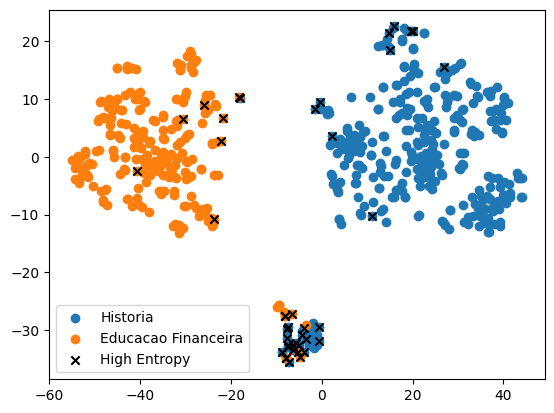

In [24]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.scatter(all_vectors_tsne[df['high_entropy'] == 1, 0], all_vectors_tsne[df['high_entropy'] == 1, 1], label="High Entropy", color="black", marker="x")
plt.legend()
plt.show()

# Para hoje/amanhã

1. Escolham duas playlists do youtube com temas distintos ou realizem scrapping de conteúdos distintos
2. Tomem os embeddings dos vídeos/conteúdos
3. Comparem os embeddings de cada segmento em um gráfico bidimensional.
4. Treinem um classificador em cima dos embeddings dos chunks.
5. Analisem quais chunks o modelo treinado mais teve dificuldade em classificar.
6. **(EXTRA/DESAFIO)**: Busquem o 'tema' central dos conteúdos (ou seja, identifique os centróides dos embeddings); Selecione um dos temas centrais e busque os chunks/embeddings que estão mais relacionados a este tema central (vocês podem utilizar a famosa `similaridade cosseno` from scratch mesmo para buscar os embeddings mais próximos --- semanticamente --- e consequentemente os chunks associados)

<h1> Resolução

instalações e pacotes necessários

In [35]:
# %pip install --upgrade --quiet  youtube-transcript-api
# %pip install --upgrade --quiet  pytube

In [25]:
from langchain_community.document_loaders import YoutubeLoader
from pytube import Playlist
from pytube.exceptions import PytubeError
from youtube_transcript_api import NoTranscriptFound

Escolhendo playlists e salvando em documentos

In [26]:
playlist_trico = Playlist("https://www.youtube.com/watch?v=-Taffz0Cq_U&list=PLRUR8ndb4lMpP4-jMxuq2AQhDbkLai4xL") 
playlist_canto = Playlist("https://www.youtube.com/watch?v=Z6-dUR-y_CI&list=PLVakHlcZgmOZF2vn-1pDT4fr4rtixbHsB")

In [27]:
urls_trico = playlist_trico.video_urls
urls_canto = playlist_canto.video_urls

In [28]:
urls_trico

['https://www.youtube.com/watch?v=-Taffz0Cq_U', 'https://www.youtube.com/watch?v=aOKFgOGGooo', 'https://www.youtube.com/watch?v=yNCoMYc33d8', 'https://www.youtube.com/watch?v=6LjF1eG_tkM', 'https://www.youtube.com/watch?v=nGFUczGTejw', 'https://www.youtube.com/watch?v=3P7ntTkafPI', 'https://www.youtube.com/watch?v=I7W4eEvsAko', 'https://www.youtube.com/watch?v=tBcW894DzUU', 'https://www.youtube.com/watch?v=1795kv92lw4', 'https://www.youtube.com/watch?v=GjP_ZDnH6Rc', 'https://www.youtube.com/watch?v=Vru6iebjdZU', 'https://www.youtube.com/watch?v=6ix7Ir9n4Pc', 'https://www.youtube.com/watch?v=lnGi69IDvZ8', 'https://www.youtube.com/watch?v=X7bzru0KP5Q', 'https://www.youtube.com/watch?v=tY2i2rBDYg8', 'https://www.youtube.com/watch?v=NfMYRpnXuz4', 'https://www.youtube.com/watch?v=9QJGKZMkqSg', 'https://www.youtube.com/watch?v=nGuN8BPmkBw', 'https://www.youtube.com/watch?v=zad1ChHbAMw', 'https://www.youtube.com/watch?v=_4qFDrDjvvU', 'https://www.youtube.com/watch?v=PRNHH6goyHg', 'https://www

In [29]:
urls_canto

['https://www.youtube.com/watch?v=Z6-dUR-y_CI', 'https://www.youtube.com/watch?v=PDJZxm45LKc', 'https://www.youtube.com/watch?v=kmiHH1t3jFg', 'https://www.youtube.com/watch?v=v6GGDnMCwVc', 'https://www.youtube.com/watch?v=ynsl3Ia15GQ', 'https://www.youtube.com/watch?v=N2eNqQc-8og', 'https://www.youtube.com/watch?v=hEQY-9CPGL4', 'https://www.youtube.com/watch?v=3ohwVX-YAck', 'https://www.youtube.com/watch?v=v1KBkVNiSrE', 'https://www.youtube.com/watch?v=Qdh0zY7tYRU', 'https://www.youtube.com/watch?v=Re-Qn1wlJH4', 'https://www.youtube.com/watch?v=I0o842w9Zg8', 'https://www.youtube.com/watch?v=yPRH7DhyNjc', 'https://www.youtube.com/watch?v=VfsZ0AlHepI', 'https://www.youtube.com/watch?v=eiLaE8Bdjvc', 'https://www.youtube.com/watch?v=PdawmdbXHxM', 'https://www.youtube.com/watch?v=weKXUAvlHJo', 'https://www.youtube.com/watch?v=3ISm538yuXk', 'https://www.youtube.com/watch?v=X_InhwDQE8g', 'https://www.youtube.com/watch?v=yKycrTdHh1Y', 'https://www.youtube.com/watch?v=lITIA70tBTc', 'https://www

In [30]:
def cria_documento(urls):
    documents = []
    for video in urls:
        loader = YoutubeLoader.from_youtube_url(video, add_video_info=False, language=["pt"])
        try:
            doc = loader.load()
            if len(doc) > 0:
                documents.append(doc[0])  # Adiciona a transcrição ao documents
        except NoTranscriptFound:
            print(f"Nenhuma transcrição encontrada para o vídeo {video} em pt-BR.")
        except Exception as e:
            print(f"Erro ao carregar o vídeo {video}: {e}")
    return documents

In [31]:
doc_trico = cria_documento(urls_trico)

In [32]:
doc_canto = cria_documento(urls_canto)

Nenhuma transcrição encontrada para o vídeo https://www.youtube.com/watch?v=NR6VgKOSUMQ em pt-BR.


In [33]:
doc_trico

[Document(metadata={'source': '-Taffz0Cq_U'}, page_content='Oi tudo bem vem aprender no vídeo de hoje como colocar os pontos na agulha de tricô de três maneiras fáceis e simples de uma forma bem clara e objetiva então pegue seus fios e suas agulhas e vamos começar a trabalhar bom pessoal os materiais necessários que você vai utilizar para fazer a montagem de pontos na agulha de tricô são um par de agulhas de tricô aqui eu tenho par de agulhas de tricô de número 6 e um novelo de lã ou barbante que seja compatível com essas agulhas e como eu vou saber que Alan ou barbante é compatível com agulha aqui na embalagem desta lã vem escrito o peso contém 100g vem a metragem contém 133 metros e esse símbolo das Agulhas cruzadas indicam as agulhas indicadas para essa lã no caso as agulhas de 5 a 6 mm e vamos para espaço a paz esse primeiro método que você vai aprender é um método mais fácil e mais simples que se tem de como colocar os pontos na agulha de tricô primeiro de tudo pegue o seu fio dob

In [34]:
doc_canto

[Document(metadata={'source': 'Z6-dUR-y_CI'}, page_content='então você acha que é impossível cantar que a sua voz parece uma taquara rachada e que só aqueles que têm o dom podem cantar eu sou anne e tá aqui pra te mostrar que tem jeito sim no vídeo de hoje a gente fala de respiração não fazer um exercício sobre respiração porque é muito importante no canto existem frases musicais em que você tem que sustentar uma nota por muito tempo ou então existem outras frases em que você tem que cantar muitas notas e você não tem brecha para respirar então nesses casos você precisa ter um bom fôlego e pra isso é importante fazer o exercício desse vídeo não só hoje não só agora mas sempre para que você consiga cada vez mais melhorar a sua capacidade respiratória você sabia que existem três tipos de respiração uma delas eu tenho certeza que você faz e você nem percebe que a respiração toráxica porque é assim ó aquela respiração pensa quando você está atrasado quando você tem uma prova quando você pe

Criando os chunks

In [35]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500,
    length_function=len,
    is_separator_regex=False,
)

In [36]:
chunks_trico = text_splitter.split_documents(doc_trico)
chunks_canto = text_splitter.split_documents(doc_canto)

Criando os embeddings

In [37]:
vectors_trico = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_trico]))
vectors_canto = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_canto]))

In [38]:
all_vectors = np.concatenate([vectors_trico, vectors_canto], axis=0)

<h2> Comparando os vetores

reduzindo dimensionalidade

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
all_vectors_tsne = tsne.fit_transform(all_vectors)

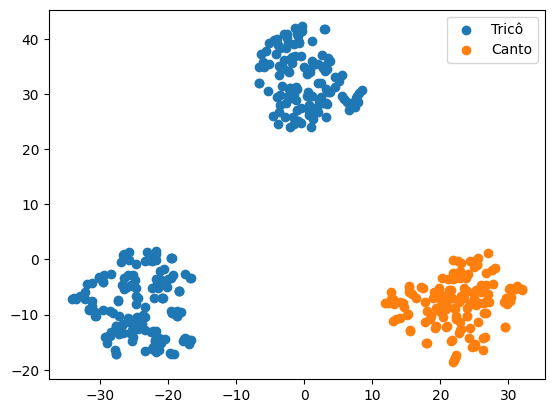

In [40]:
plt.scatter(all_vectors_tsne[:len(vectors_trico), 0], all_vectors_tsne[:len(vectors_trico), 1], label="Tricô")
plt.scatter(all_vectors_tsne[len(vectors_trico):, 0], all_vectors_tsne[len(vectors_trico):, 1], label="Canto")
plt.legend()
plt.show()

<h2> Classificador

In [41]:
input_size = embedding_size
criterion = nn.CrossEntropyLoss()
classifier = Classifier(input_size, 100, 2)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

X = torch.tensor(all_vectors, dtype=torch.float32)
y = torch.tensor([0]*len(vectors_trico) + [1]*len(vectors_canto), dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.7044533491134644
Epoch 1 Loss: 0.6930952072143555
Epoch 2 Loss: 0.6824513077735901
Epoch 3 Loss: 0.6707503795623779
Epoch 4 Loss: 0.6582809686660767
Epoch 5 Loss: 0.6451684236526489
Epoch 6 Loss: 0.6314215660095215
Epoch 7 Loss: 0.6171150803565979
Epoch 8 Loss: 0.6024042367935181
Epoch 9 Loss: 0.5873841047286987
Epoch 10 Loss: 0.5721665024757385
Epoch 11 Loss: 0.5568827390670776
Epoch 12 Loss: 0.5416426658630371
Epoch 13 Loss: 0.5265237092971802
Epoch 14 Loss: 0.5116227865219116
Epoch 15 Loss: 0.49704670906066895
Epoch 16 Loss: 0.4829091429710388
Epoch 17 Loss: 0.46931400895118713
Epoch 18 Loss: 0.4563336968421936
Epoch 19 Loss: 0.44402727484703064
Epoch 20 Loss: 0.43244045972824097
Epoch 21 Loss: 0.4216075539588928
Epoch 22 Loss: 0.41154640913009644
Epoch 23 Loss: 0.4022587835788727
Epoch 24 Loss: 0.3937343657016754
Epoch 25 Loss: 0.3859514892101288
Epoch 26 Loss: 0.3788818120956421
Epoch 27 Loss: 0.37248826026916504
Epoch 28 Loss: 0.3667292296886444
Epoch 29 Loss: 0.3

In [43]:
from sklearn.metrics import accuracy_score, classification_report

outputs_test = classifier(X_test)
_, predicted = torch.max(outputs_test, 1)

print(accuracy_score(y_test, predicted))

1.0


In [44]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        25

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [45]:
def shannon_entropy(p):
    return -np.sum(p * np.log2(p))

all_outputs = classifier(X)
entropy = np.array([shannon_entropy(x) for x in all_outputs.detach().numpy()])
all_chunks = np.array([x.page_content for x in (chunks_trico + chunks_canto)])

df = pd.DataFrame({"entropy": entropy, 
                   "text": all_chunks, 
                   "label": y.numpy()})

In [46]:
df.sort_values("entropy", ascending=False).head(75)

,entropy,text,label
122,0.308872,E aí E aí Ah E assim encerramos a nossa quarta...,0
103,0.303938,duas perninhas desta forma e vai pegar uma per...,0
179,0.282722,vai criar uma segurança pronto finalizado a no...,0
316,0.232622,episode of extra bed minimize mojiko LOV decir...,1
397,0.212265,primeira coisa a gente vai começar com relaxam...,1
...,...,...,...
222,0.043080,"hat here, making the seam invisible. And you w...",0
4,0.042883,polegar e o seu dedo indicador sobre a ponta q...,0
171,0.042630,ondinhas aqui como vocês podem ver agora vamos...,0
112,0.042555,você irá trabalhar na seguinte sequência fazen...,0


In [47]:
df.iloc[122,1]

'E aí E aí Ah E assim encerramos a nossa quarta carreira trabalhando todos os pontos em ponto meia e assim vai ficando a nossa amostrinha como vocês podem ver e que esses quadradinhos com essas divisões dessas ondinhas e do outro lado fica deste jeito e basta você repetir essas quatro carreiras até você atingir o tamanho desejado se você gostou deixa aquele super like que ajuda bastante na divulgação deste vídeo se inscreve no canal e ativa as notificações Porque toda semana Tem vídeo novo aqui no canal vem fazer parte desta comunidade que apaixonada por trabalhos manuais eu te espero no próximo vídeo forte abraço e valeu'

In [48]:
df['high_entropy'] = df['entropy'] > 0.1

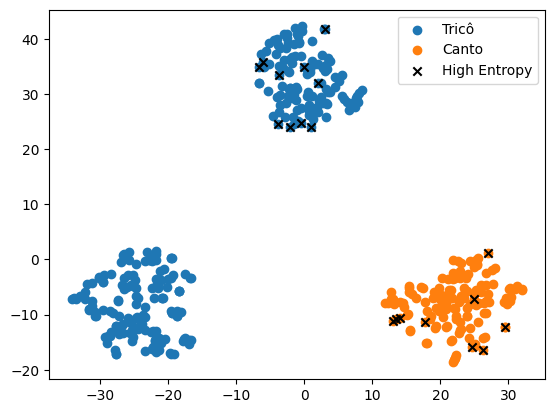

In [49]:
plt.scatter(all_vectors_tsne[:len(vectors_trico), 0], all_vectors_tsne[:len(vectors_trico), 1], label="Tricô")
plt.scatter(all_vectors_tsne[len(vectors_trico):, 0], all_vectors_tsne[len(vectors_trico):, 1], label="Canto")
plt.scatter(all_vectors_tsne[df['high_entropy'] == 1, 0], all_vectors_tsne[df['high_entropy'] == 1, 1], label="High Entropy", color="black", marker="x")
plt.legend()
plt.show()

<h2> Desafio

In [50]:
centroide_trico = np.mean(vectors_trico, axis=0)
centroide_canto = np.mean(vectors_canto, axis=0)

In [51]:
centroide_canto

array([ 0.02441561,  0.02021398, -0.01184084, ..., -0.00129828,
        0.00094564,  0.00021871], shape=(1536,))

Função lambda similaridade de cosseno para vetores 1D

In [52]:
cossine_similarity = lambda u, v: np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [53]:
def buscar_chunks_proximos(embeddings, chunks, centroide, top_n=5):
    """
    Busca os chunks mais próximos semanticamente de um centróide.

    Args:
        embeddings (list): Lista de embeddings.
        chunks (list): Lista de textos correspondentes aos embeddings.
        centroide (numpy.ndarray): O vetor centróide.
        top_n (int): Número de chunks mais próximos a retornar.

    Returns:
        list: Lista dos chunks mais próximos.
    """
    similaridades = [
        (i, cossine_similarity(embedding, centroide))
        for i, embedding in enumerate(embeddings)
    ]
    similaridades = sorted(similaridades, key=lambda x: x[1], reverse=True)
    top_chunks = [chunks[i] for i, _ in similaridades[:top_n]]
    return top_chunks

In [54]:
top_chunks = buscar_chunks_proximos(all_vectors, all_chunks, centroide_canto, top_n=5)
top_chunks

[np.str_('fala cantantes tudo bem mais um exercício da nossa série de vocalizes de afinação Então a gente vai aumentar um pouquinho aquela melodia que já tá grande né já me conta aí nos comentários da onde vocês estão vendo esse vídeo de qual cidade de qual país que eu tô bem curiosa vamos lembrar um pouquinho da sequência que a gente estava fazendo antes né que era primeiro [Música] foi o segundo foi terceiro foi mini mini mini mi o quarto mini mini mini e o anterior nosso último vídeo de afinação mini E é claro que a gente vai aumentar um pouquinho essa melodia que vai ser min min já deu para perceber que você vai ter que ter um fôlego bom Porque durante essa melodia inteira você não vai ter brecha para respirar então aí que tá também a importância dos exercícios de respiração que muita gente morre de preguiça de fazer que eu sei e antes de começar o exercício se você quer cantar para mim se você quer que eu te corrija se você quer aprender a cantar do zero eu tenho um curso pré inic

[np.int64(363), np.int64(396), np.int64(311), np.int64(326), np.int64(359)]


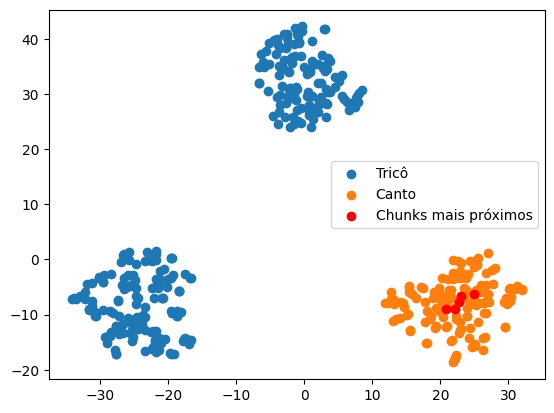

In [55]:
indices_top_chunks = [np.where(all_chunks == chunk)[0][0] for chunk in top_chunks]
indices_top_chunks

print(indices_top_chunks)

indices_top_chunks = [np.where(all_chunks == chunk)[0][0] for chunk in top_chunks]
top_embeddings_2d = all_vectors_tsne[indices_top_chunks]

plt.scatter(all_vectors_tsne[:len(vectors_trico), 0], all_vectors_tsne[:len(vectors_trico), 1], label="Tricô")
plt.scatter(all_vectors_tsne[len(vectors_trico):, 0], all_vectors_tsne[len(vectors_trico):, 1], label="Canto")
plt.scatter(top_embeddings_2d[:, 0], top_embeddings_2d[:, 1], color='red', label="Chunks mais próximos")
plt.legend()
plt.show()